In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.utils import shuffle

import forestci as fci
import seaborn as sns

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

%matplotlib inline

In [2]:
# plt.style.use('fivethirtyeight')
plt.style.use('seaborn')

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    'mathtext.default': 'regular'
}

plt.rcParams.update(tex_fonts)

/tmp/ipykernel_5658/1548682167.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
def read_files(ue_file, gnb_file, drop_first=None):
    # read file and drop first column
    if drop_first:
        ue = pd.read_csv(ue_file).iloc[:, 1:]
        gnb = pd.read_csv(gnb_file).iloc[:, 1:]
    else:
        ue = pd.read_csv(ue_file)
        gnb = pd.read_csv(gnb_file)
    
    # Set timestep as index
    ue = ue.set_index('timeStep', drop=True)
    ue.index = pd.to_datetime(ue.index, unit='s')
    
    
    gnb = gnb.set_index('timeStep', drop=True)
    gnb.index = pd.to_datetime(gnb.index, unit='s')
    
    # resample to 100 ms
    gnb = gnb.resample('100L').mean()
    return ue, gnb

In [4]:
def create_and_merge_df(ue, gnb):
    master_df = pd.DataFrame()
    
    veh_ids = ue.groupby('vehId')
    for veh_id in veh_ids.groups:
        temp = veh_ids.get_group(veh_id)
        gnb_temp = gnb.loc[(gnb.index >= temp.index[0]) & (gnb.index <= temp.index[-1])]
        gnb_temp = gnb_temp.rename(columns={'lastPosX': 'bs_x',
                                            'lastPosY': 'bs_y'})
        temp = temp.join(gnb_temp)
        
        master_df = pd.concat([master_df, temp])
    return master_df

In [5]:
def preprocess_data(df):
    # calculate distance between veh and BS
    df['Distance'] = np.sqrt(np.power((df.lastPosX - df.bs_x), 2) + np.power((df.lastPosY - df.bs_y), 2))
    
    # drop columns
    df.drop(['lastPosX', 'lastPosY', 'bs_x', 'bs_y', 'lastOrientation', 'gNodeBId', 'distance'], axis=1, inplace=True)
    
    # fill NANs
    df = df.fillna(0)
    
    return df

# Training and Testing Data

In [57]:
veh = pd.read_csv('dataset_VoIP-UL_car_20220921.csv')
gnodeb = pd.read_csv('dataset_VoIP-UL_gNodeB_20220921.csv')

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [50]:
def split_data(df, test_size, method=None):    
    if method is None or method == 'random':
        labels = np.array(df['voIPGeneratedThroughput'])
        df.drop(['voIPGeneratedThroughput'], axis=1, inplace=True)
        df_series = np.array(df)
        train_features, test_features, train_labels, test_labels = train_test_split(df_series, labels, test_size = test_size, random_state = 42)
    elif method == 'vehicle':
        train = pd.DataFrame()
        test = pd.DataFrame()      
        
        veh_ids = df.groupby('vehId')
        for vid in veh_ids.groups:
            temp = veh_ids.get_group(vid)
            split_size = int(np.floor(temp.shape[0] * (1-test_size)))
            index_split = int(np.floor(temp.index.values.shape[0] * (1-test_size)))
            split_value = list(temp.index.values)[index_split]
            
            temp_train = temp.loc[temp.index < split_value].copy()
            temp_test = temp.loc[temp.index >= split_value].copy()
            
            train = pd.concat([train, temp_train])
            test = pd.concat([test, temp_test])
        
        train = train.sort_index()
        train = test.sort_index()
        
        train_labels = train['voIPGeneratedThroughput'].values
        train.drop(['voIPGeneratedThroughput'], axis=1, inplace=True)
        train_features = np.array(train.copy())
        
        test_labels = test['voIPGeneratedThroughput'].values
        test.drop(['voIPGeneratedThroughput'], axis=1, inplace=True)
        test_features = np.array(test.copy())
        
    else:
        print('Error!')
    
    return train_features, train_labels, test_features, test_labels

In [51]:
ue_df, gnb_df = read_files('dataset_VoIP-UL_car_20220921.csv', 'dataset_VoIP-UL_gNodeB_20220921.csv', drop_first=True)
df = create_and_merge_df(ue_df, gnb_df)
df = preprocess_data(df)
train_features, train_labels, test_features, test_labels = split_data(df, 0.25, 'vehicle')

In [52]:
df

,vehId,lastVelocity,measuredSinrUl,measuredSinrDl,rcvdSinrUl,rcvdSinrDl,averageCqiUl,averageCqiDl,voIPGeneratedThroughput,macDelayUl,distancemeasuredSinrUl,avgServedBlocksUl,avgServedBlocksDl,macDelayDl,incomingDataRate,outgoingDataRate,Distance
timeStep,,,,,,,,,,,,,,,,,
1970-01-01 00:00:09.200,0,22.712978,6.393036,20.809610,8.077635,0.000000,5.0,0.0,26.086957,0.0040,0.0,0.095,0.000,41600.0,20800.0,20800.0,663.853071
1970-01-01 00:00:09.300,0,22.778171,6.766056,20.934431,1.692643,0.000000,5.0,0.0,47.311828,0.0058,0.0,0.135,0.000,41600.0,20800.0,20800.0,662.247075
1970-01-01 00:00:09.400,0,22.856097,0.842261,29.462213,4.264864,0.000000,3.0,0.0,68.085106,0.0040,0.0,0.145,0.000,41600.0,20800.0,20800.0,660.639554
1970-01-01 00:00:09.500,0,22.861574,0.523233,35.342371,-0.914933,0.000000,3.0,0.0,88.421053,0.0040,0.0,0.110,0.000,41600.0,20800.0,20800.0,659.035654
1970-01-01 00:00:09.600,0,22.897601,5.192960,34.936258,-4.250740,0.000000,4.0,0.0,108.333333,0.0058,0.0,0.080,0.000,41600.0,20800.0,20800.0,657.433274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:01:39.600,21,13.388120,11.027157,32.825307,1.740581,14.284669,3.0,10.0,12.563323,0.0040,0.0,0.370,0.225,370364.8,185182.4,185182.4,651.654193
1970-01-01 00:01:39.700,21,13.455495,11.335826,34.234467,1.740581,14.284669,3.0,10.0,12.563323,0.0040,0.0,0.360,0.200,345404.8,172702.4,172702.4,650.723307
1970-01-01 00:01:39.800,21,13.465944,11.332609,35.454650,1.740581,14.284669,3.0,10.0,12.563323,0.0040,0.0,0.360,0.200,328681.6,164340.8,164340.8,649.793153


In [10]:
test_labels.shape

(1574,)

# ML Models

## Random Forest Regressor

In [11]:
from sklearn.ensemble import RandomForestRegressor

## Test 2 - 23/09/2022

### 1. Forecasting

In [12]:
rf = RandomForestRegressor(n_estimators = 750, random_state = 42)

In [13]:
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=750, random_state=42)

In [14]:
predictions = rf.predict(test_features)

In [15]:
errors = abs(predictions - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 1.11


In [16]:
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 99.68 %.


In [17]:
predictions

array([1234.91608897, 1237.33725405, 1246.69237663, ...,   13.60215411,
         14.44971103,   15.29612828])

In [18]:
train_labels

array([1243.19456202, 1245.38186125, 1247.55655357, ...,  548.83140859,
        379.64487266,   12.5633232 ])

In [19]:
importances = list(rf.feature_importances_)

In [29]:
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: vehId                Importance: 0.83
Variable: lastVelocity         Importance: 0.15
Variable: outgoingDataRate     Importance: 0.01
Variable: measuredSinrUl       Importance: 0.0
Variable: measuredSinrDl       Importance: 0.0
Variable: rcvdSinrUl           Importance: 0.0
Variable: rcvdSinrDl           Importance: 0.0
Variable: averageCqiUl         Importance: 0.0
Variable: averageCqiDl         Importance: 0.0
Variable: voIPGeneratedThroughput Importance: 0.0
Variable: macDelayUl           Importance: 0.0
Variable: distancemeasuredSinrUl Importance: 0.0
Variable: avgServedBlocksUl    Importance: 0.0
Variable: avgServedBlocksDl    Importance: 0.0
Variable: macDelayDl           Importance: 0.0
Variable: incomingDataRate     Importance: 0.0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

### Test 1 - 20/09/2022

In [25]:
labels = np.array(df['rcvdSinrUl'])

In [26]:
# df = df.drop('rcvdSinrUl', axis=1)
df = df.fillna(0)

In [27]:
feature_list = list(df.columns)

In [28]:
feature_list

['vehId',
 'lastVelocity',
 'measuredSinrUl',
 'measuredSinrDl',
 'rcvdSinrUl',
 'rcvdSinrDl',
 'averageCqiUl',
 'averageCqiDl',
 'voIPGeneratedThroughput',
 'macDelayUl',
 'distancemeasuredSinrUl',
 'avgServedBlocksUl',
 'avgServedBlocksDl',
 'macDelayDl',
 'incomingDataRate',
 'outgoingDataRate',
 'Distance']

In [30]:
df_series = np.array(df)

In [31]:
train_features, test_features, train_labels, test_labels = train_test_split(df_series, labels, test_size = 0.25, random_state = 42)

In [32]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (4700, 17)
Training Labels Shape: (4700,)
Testing Features Shape: (1567, 17)
Testing Labels Shape: (1567,)


### Baseline Predictions

In [33]:
baseline_preds = np.full(shape=test_features.shape[0], fill_value=max(labels))

In [34]:
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  25.09


In [35]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [36]:
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [37]:
predictions = rf.predict(test_features)

In [38]:
errors = abs(predictions - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.01


In [39]:
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 100.01 %.


In [40]:
importances = list(rf.feature_importances_)

In [41]:
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: rcvdSinrUl           Importance: 1.0
Variable: vehId                Importance: 0.0
Variable: lastVelocity         Importance: 0.0
Variable: measuredSinrUl       Importance: 0.0
Variable: measuredSinrDl       Importance: 0.0
Variable: rcvdSinrDl           Importance: 0.0
Variable: averageCqiUl         Importance: 0.0
Variable: averageCqiDl         Importance: 0.0
Variable: voIPGeneratedThroughput Importance: 0.0
Variable: macDelayUl           Importance: 0.0
Variable: distancemeasuredSinrUl Importance: 0.0
Variable: avgServedBlocksUl    Importance: 0.0
Variable: avgServedBlocksDl    Importance: 0.0
Variable: macDelayDl           Importance: 0.0
Variable: incomingDataRate     Importance: 0.0
Variable: outgoingDataRate     Importance: 0.0
Variable: Distance             Importance: 0.0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [42]:
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

In [43]:
important_indices = [feature_list.index('averageCqiUl'), feature_list.index('measuredSinrUl')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

In [44]:
rf_most_important.fit(train_important, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [45]:
predictions = rf_most_important.predict(test_important)

In [46]:
errors = abs(predictions - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 2.95


In [47]:
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 60.26 %.


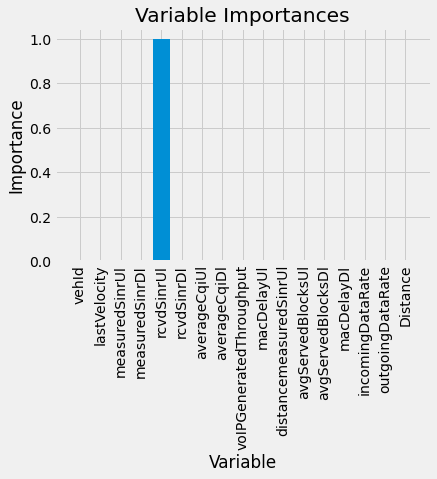

In [48]:
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

### Test 1 - 2022/09/26 - Anjie

In [72]:
df_car = pd.read_csv('dataset_VoIP-UL_car_20220926.csv')

In [75]:
df_car.groupby('vehId')

In [92]:
df_car.lastPosX.describe()

count    6267.000000
mean      490.874322
std       308.393790
min        26.049910
25%       206.826601
50%       462.134564
75%       771.361750
max      1024.713793
Name: lastPosX, dtype: float64

## Prediction method 1: conventional prediction based on pass

## Attemp 1: prediction for all the vehicles

In [7]:
df_car_low = pd.read_csv('dataset_VoIP-UL_car_low_traffic_20221007.csv')
df_car_med = pd.read_csv('dataset_VoIP-UL_car_medium_traffic_20221007.csv')
df_car_high = pd.read_csv('dataset_VoIP-UL_car_high_traffic_20221007.csv')

<AxesSubplot:>

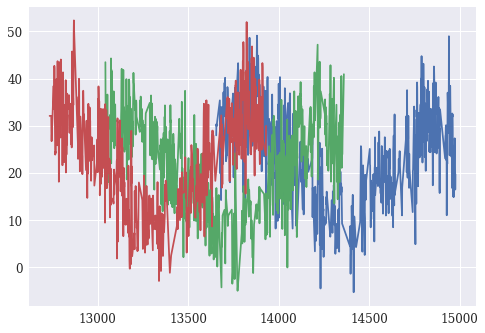

In [13]:
df_car_low.loc[df_car_low.vehId == 10].rcvdSinrDl.plot()
df_car_med.loc[df_car_med.vehId == 10].rcvdSinrDl.plot()
df_car_high.loc[df_car_high.vehId == 10].rcvdSinrDl.plot()

In [8]:
df_car = pd.concat([df_car_low, df_car_med, df_car_high])
df_car = df_car.fillna(0)

In [484]:
df_car = pd.read_csv('dataset_VoIP-UL_car_20220926.csv')
#df_car = df_car.dropna()
df_car = df_car.fillna(0)

In [485]:
# # prediction for one single car
# df_car = df_car.loc[df_car.vehId == 0]

In [9]:
x = df_car[['timeStep', 'vehId', 'lastPosX', 'lastPosY',
            'lastVelocity', 'lastOrientation', 'distance']]

In [10]:
y = df_car[['measuredSinrUl', 'measuredSinrDl', 
                 'rcvdSinrUl', 'rcvdSinrDl',
                 'averageCqiUl', 'averageCqiDl', 'servingCell',
                 'voIPGeneratedThroughput', 'macDelayUl']]

In [11]:
x

,timeStep,vehId,lastPosX,lastPosY,lastVelocity,lastOrientation,distance
0,20.0,0,302.158120,29.8,27.148757,0.000000,4231.142221
1,20.1,0,304.879227,29.8,27.211078,0.000000,3858.041538
2,20.2,0,307.608118,29.8,27.288901,0.000000,3484.940855
3,20.3,0,310.339035,29.8,27.309171,0.000000,3111.840172
4,20.4,0,313.075974,29.8,27.369397,0.000000,2738.739489
...,...,...,...,...,...,...,...
189278,199.6,179,5019.171576,20.2,1.307147,-3.141593,734.996228
189279,199.7,179,5019.033977,20.2,1.375989,-3.141593,734.937330
189280,199.8,179,5018.891181,20.2,1.427963,-3.141593,734.842097
189281,199.9,179,5018.747852,20.2,1.433288,-3.141593,734.738882


In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=48)

In [13]:
model = RandomForestRegressor(n_estimators= 100, random_state=42)

In [14]:
model.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

In [492]:
# feature importance

In [15]:
feature_names = x.columns
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
model_importances = pd.Series(importances, index=feature_names)

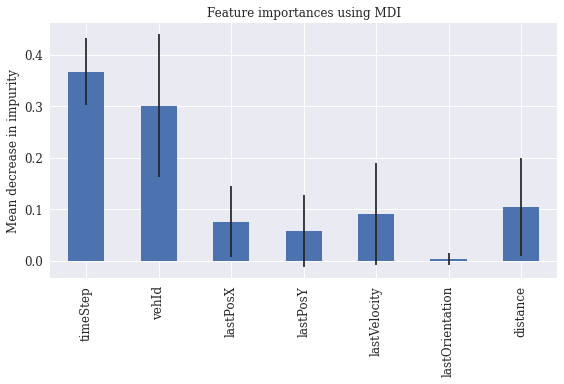

In [16]:
fig, ax = plt.subplots()
model_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances using MDI')
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [17]:
y_pred = model.predict(x_test)

In [496]:
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("\nRMSE: ", rmse)


RMSE:  2.517


In [18]:
y_pred = pd.DataFrame(y_pred, columns=y_test.columns)

10.718511706563556

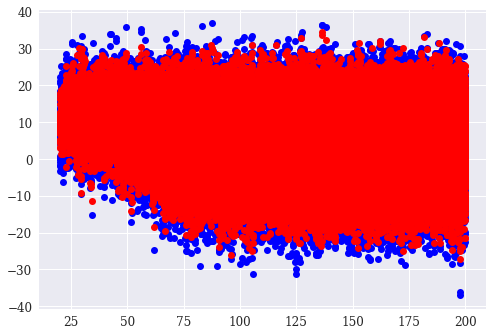

In [19]:
plt.plot(x_test.timeStep, y_test.measuredSinrUl, 'ob')
plt.plot(x_test.timeStep, y_pred.measuredSinrUl, 'or')
mean_squared_error(y_test.measuredSinrUl, y_pred.measuredSinrUl)

15.322774747368188

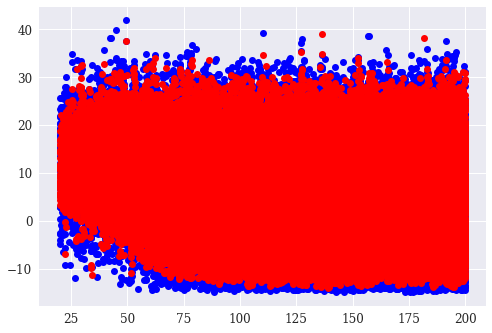

In [20]:
plt.plot(x_test.timeStep, y_test.rcvdSinrUl, 'ob')
plt.plot(x_test.timeStep, y_pred.rcvdSinrUl, 'or')
mean_squared_error(y_test.rcvdSinrUl, y_pred.rcvdSinrUl)

1.0124800702638102

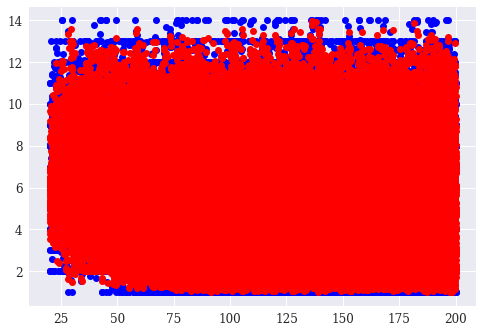

In [21]:
plt.plot(x_test.timeStep, y_test.averageCqiUl, 'ob')
plt.plot(x_test.timeStep, y_pred.averageCqiUl, 'or')
mean_squared_error(y_test.averageCqiUl, y_pred.averageCqiUl)

0.0029964168198308703

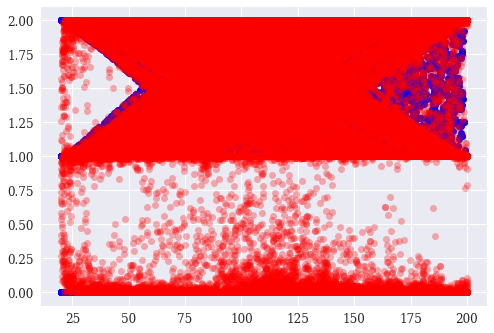

In [23]:
plt.plot(x_test.timeStep, y_test.servingCell, 'ob')
plt.plot(x_test.timeStep, y_pred.servingCell, 'or', alpha=.3)
mean_squared_error(y_test.servingCell, y_pred.servingCell)

## Prediction method 2: Markov chain prediction

## Attempt 1: prediction for all vehicles

In [502]:
df_car = pd.read_csv('dataset_VoIP-UL_car_20220926.csv')
df_car = df_car.fillna(0)

In [503]:
x = df_car[['timeStep', 'vehId', 'lastPosX', 'lastPosY',
            'lastVelocity', 'lastOrientation', 'distance']]
y = df_car[['measuredSinrUl', 'measuredSinrDl', 
                 'rcvdSinrUl', 'rcvdSinrDl',
                 'averageCqiUl', 'averageCqiDl',
                 'voIPGeneratedThroughput', 'macDelayUl']]

In [504]:
# x = df_car[['timeStep', 'vehId', 'lastPosX', 'lastPosY',
#             'lastVelocity', 'lastOrientation', 'distance',
#             'measuredSinrUl', 'measuredSinrDl',
#             'averageCqiUl', 'averageCqiDl',
#             'macDelayUl']]
# y = df_car[['rcvdSinrUl', 'rcvdSinrDl',
#             'voIPGeneratedThroughput']]

In [517]:
# Split the first half of the data as the training data
# x_train1, x_train2, y_train1, y_train2 = train_test_split(
# ...   x, y, train_size=0.5, random_state=48, shuffle=False)
train_size = int(x.shape[0]/10*9)

x_train1 = x.iloc[:train_size, :]
y_train1 = y.iloc[:train_size, :]

In [518]:
# Split par of the second data as the test data
# test_interval = x_train2.shape[0]/100
test_interval = 50

In [519]:
x_test1 = x.iloc[train_size:train_size+test_interval, :]
y_test1 = y.iloc[train_size:train_size+test_interval, :]

In [520]:
# Create rfr
model = RandomForestRegressor(n_estimators=100, random_state=42)

In [521]:
# Do the first prediction

In [522]:
model.fit(x_train1, y_train1)

RandomForestRegressor(random_state=42)

In [523]:
y_pred1 = model.predict(x_test1)
y_pred1 = pd.DataFrame(y_pred1, columns=y_test1.columns)

In [524]:
feature_names = x.columns
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
model_importances = pd.Series(importances, index=feature_names)

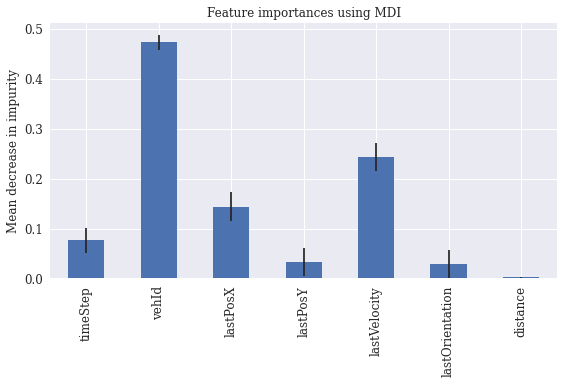

In [525]:
fig, ax = plt.subplots()
model_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances using MDI')
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

22.565551962593418

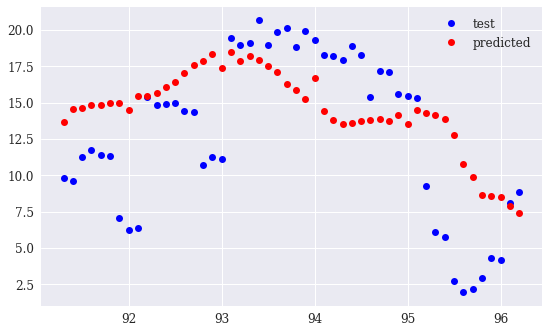

In [526]:
plt.plot(x_test1.timeStep, y_test1.measuredSinrUl, 'ob', label='test')
plt.plot(x_test1.timeStep, y_pred1.measuredSinrUl, 'or', label='predicted')
plt.legend()
mean_squared_error(y_test1.measuredSinrUl, y_pred1.measuredSinrUl)

28.222249020684067

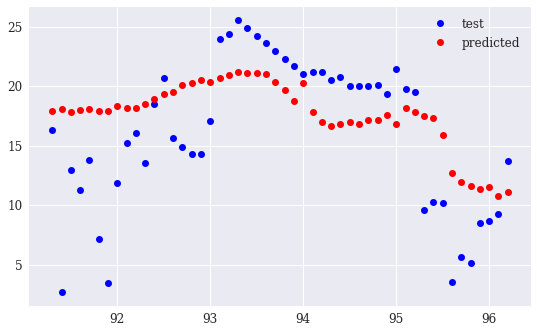

In [527]:
plt.plot(x_test1.timeStep, y_test1.rcvdSinrUl, 'ob', label='test')
plt.plot(x_test1.timeStep, y_pred1.rcvdSinrUl, 'or', label='predicted')
plt.legend()
mean_squared_error(y_test1.rcvdSinrUl, y_pred1.rcvdSinrUl)

280.5469869674192

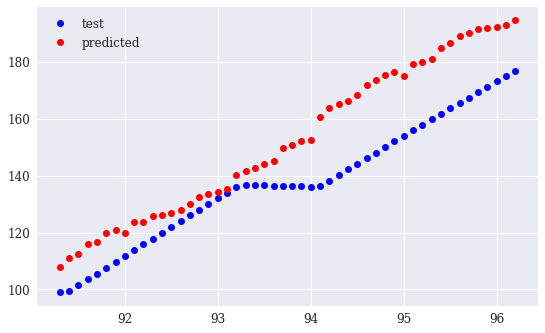

In [528]:
plt.plot(x_test1.timeStep, y_test1.voIPGeneratedThroughput, 'ob', label='test')
plt.plot(x_test1.timeStep, y_pred1.voIPGeneratedThroughput, 'or', label='predicted')
plt.legend()
mean_squared_error(y_test1.voIPGeneratedThroughput, y_pred1.voIPGeneratedThroughput)

## Attemp2: prediction for single car

In [559]:
df_car = pd.read_csv('dataset_VoIP-UL_car_20220926.csv')
df_car = df_car.fillna(0)

In [560]:
x = df_car[['timeStep', 'vehId', 'lastPosX', 'lastPosY',
            'lastVelocity', 'lastOrientation', 'distance']]
y = df_car[['measuredSinrUl', 'measuredSinrDl', 
                 'rcvdSinrUl', 'rcvdSinrDl',
                 'averageCqiUl', 'averageCqiDl',
                 'voIPGeneratedThroughput', 'macDelayUl']]

In [561]:
# x = df_car[['timeStep', 'vehId', 'lastPosX', 'lastPosY',
#             'lastVelocity', 'lastOrientation', 'distance',
#             'measuredSinrUl', 'measuredSinrDl',
#             'averageCqiUl', 'averageCqiDl',
#             'macDelayUl']]
# y = df_car[['rcvdSinrUl', 'rcvdSinrDl',
#             'voIPGeneratedThroughput']]

In [562]:
X = x.loc[x.vehId == 0]
Y = y.loc[x.vehId == 0]

In [563]:
# Split the first half of the data as the training data
train_size = int(X.shape[0]/10)
X_train1 = X.iloc[:train_size, :]
Y_train1 = Y.iloc[:train_size, :]

In [564]:
test_interval = 50

In [565]:
X_test1 = X.iloc[train_size:train_size+test_interval, :]
Y_test1 = Y.iloc[train_size:train_size+test_interval, :]

In [570]:
# Do the first prediction
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train1, Y_train1)

RandomForestRegressor(random_state=42)

In [571]:
Y_pred1 = model.predict(X_test1)
Y_pred1 = pd.DataFrame(Y_pred1, columns=Y_test1.columns)

33.40730856577801

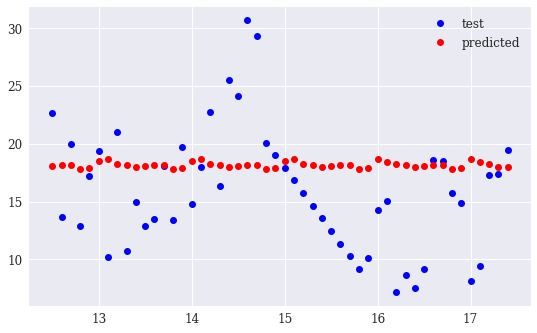

In [572]:
plt.plot(X_test1.timeStep, Y_test1.rcvdSinrUl, 'ob', label='test')
plt.plot(X_test1.timeStep, Y_pred1.rcvdSinrUl, 'or', label='predicted')
plt.legend()
mean_squared_error(Y_test1.rcvdSinrUl, Y_pred1.rcvdSinrUl)

43672.70543952999

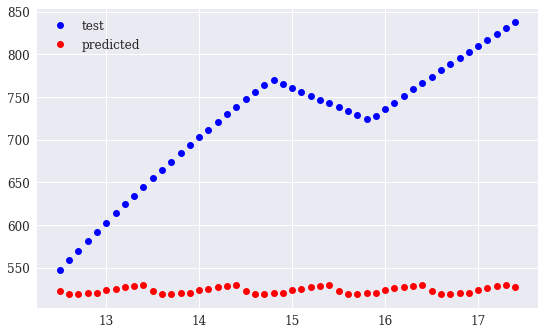

In [573]:
plt.plot(X_test1.timeStep, Y_test1.voIPGeneratedThroughput, 'ob', label='test')
plt.plot(X_test1.timeStep, Y_pred1.voIPGeneratedThroughput, 'or', label='predicted')
plt.legend()
mean_squared_error(Y_test1.voIPGeneratedThroughput, Y_pred1.voIPGeneratedThroughput)

In [577]:
X_train2 = pd.concat([X_train1, X_test1])
Y_train2 = pd.concat([Y_train1, Y_test1])

In [578]:
index1 = train_size + test_interval*1
index2 = train_size + test_interval*2

X_test2 = X.iloc[index1:index2, :]
Y_test2 = Y.iloc[index1:index2, :]

In [579]:
# Do the 2nd prediction
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train2, Y_train2)

RandomForestRegressor(random_state=42)

In [580]:
Y_pred2 = model.predict(X_test2)
Y_pred2 = pd.DataFrame(Y_pred2, columns=Y_test2.columns)

24.753888711535605

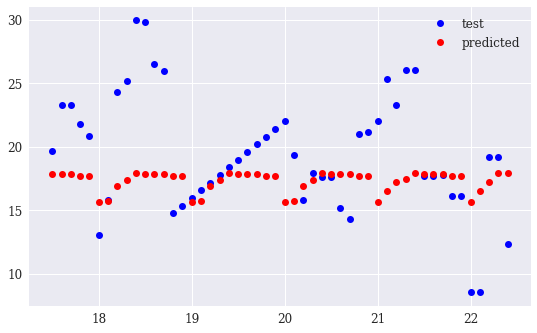

In [581]:
plt.plot(X_test2.timeStep, Y_test2.rcvdSinrUl, 'ob', label='test')
plt.plot(X_test2.timeStep, Y_pred2.rcvdSinrUl, 'or', label='predicted')
plt.legend()
mean_squared_error(Y_test2.rcvdSinrUl, Y_pred2.rcvdSinrUl)

6579.287089138421

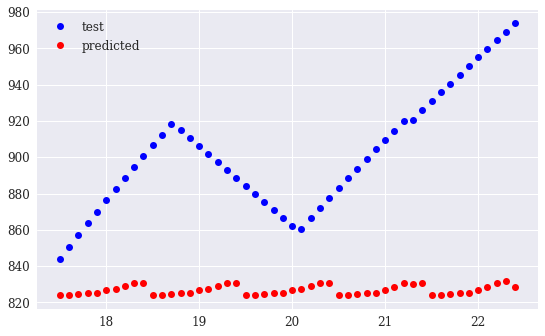

In [582]:
plt.plot(X_test2.timeStep, Y_test2.voIPGeneratedThroughput, 'ob', label='test')
plt.plot(X_test2.timeStep, Y_pred2.voIPGeneratedThroughput, 'or', label='predicted')
plt.legend()
mean_squared_error(Y_test2.voIPGeneratedThroughput, Y_pred2.voIPGeneratedThroughput)

## Atempt 3: With online learning library RIVER

In [3]:
from river import stream
from river import linear_model
from river import optim
from river import preprocessing
from river import compat
from river import compose
from river import evaluate
from river import metrics
from river import ensemble
from river import utils
from river import stats

In [4]:
from pprint import pprint
from river import datasets

In [5]:
from river import feature_extraction
from river import stats

In [6]:
from datetime import datetime

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

In [8]:
df = pd.read_csv('dataset_VoIP-UL_car_low_traffic_20221007.csv')

In [9]:
df.shape

(39527, 17)

In [10]:
df.head()

,timeStep,vehId,lastPosX,lastPosY,lastVelocity,lastOrientation,distance,measuredSinrUl,measuredSinrDl,rcvdSinrUl,rcvdSinrDl,averageCqiUl,averageCqiDl,servingCell,voIPGeneratedThroughput,macDelayUl,moment
0,20.0,0,302.158120,29.8,27.148757,0.000000,4231.142221,7.041196,29.718563,-2.466281,0.0,5.000000,0.0,2.0,2.539661e+06,0.004,1970-01-01 01:00:20
1,20.0,1,4772.975050,20.2,26.771850,-3.141593,587.472057,11.225356,20.203296,7.983300,0.0,6.000000,0.0,0.0,1.053915e+06,0.004,1970-01-01 01:00:20
2,20.1,1,4770.294426,20.2,26.806235,-3.141593,956.025974,10.715413,20.203296,13.602502,0.0,6.000000,0.0,0.0,1.289358e+05,0.004,1970-01-01 01:00:20
3,20.1,0,304.879227,29.8,27.211078,0.000000,3858.041538,7.445631,28.579888,9.055251,0.0,5.428571,0.0,2.0,1.767410e+05,0.004,1970-01-01 01:00:20
4,20.2,0,307.608118,29.8,27.288901,0.000000,3484.940855,14.034171,37.426512,15.216862,0.0,7.214286,0.0,2.0,8.873311e+04,0.004,1970-01-01 01:00:20


In [33]:
## Test of using Adaptive Random Forest Regressor

In [214]:
dataset = stream.iter_csv('dataset_VoIP-UL_car_low_traffic_20221007.csv', 
                      converters={
                          'timeStep': float,
                          'vehId': int,
                          'lastPosX': float,
                          'lastPosY': float,
                          'lastVelocity': float,
                          'lastOrientation': float,
                          'distance': float,
                          'measuredSinrUl': float,
                          'measuredSinrDl': float,
                          'rcvdSinrUl': float,
                          'rcvdSinrDl': float,
                          'averageCqiUl': float,
                          'averageCqiDl': float,
                          'servingCell': float,
                          'voIPGeneratedThroughput': float,
                          'macDelayUl': float
                      }, 
#                       parse_dates={'moment': '%Y-%m-%d %H:%M:%S'},
                      target='voIPGeneratedThroughput'
                     )

In [205]:
model = compose.Select('lastPosX', 'lastPosY', 'lastVelocity', 
                       'lastOrientation', 'distance', 'measuredSinrUl', 
                       'measuredSinrDl', 'rcvdSinrUl', 'rcvdSinrDl', 
                       'averageCqiUl', 'averageCqiDl', 'servingCell',
                       'macDelayUl'
                      )
model += (
    get_seconds |
    feature_extraction.TargetAgg(by=['vehId', 'second'], how=stats.Mean())
)
model |= preprocessing.StandardScaler()
model |= ensemble.AdaptiveRandomForestRegressor(seed=42)

In [215]:
model = compose.Select('timeStep', 'lastPosX', 'lastPosY', 'lastVelocity', 
                       'lastOrientation', 'distance', 'measuredSinrUl', 
                       'measuredSinrDl', 'rcvdSinrUl', 'rcvdSinrDl', 
                       'averageCqiUl', 'averageCqiDl', 'servingCell',
                       'macDelayUl'
                      )
model |= preprocessing.StandardScaler() 
model |= ensemble.AdaptiveRandomForestRegressor(seed=42)

In [216]:
metric = metrics.MAE()

In [217]:
evaluate.progressive_val_score(dataset, model, metric, print_every=5000)

[5,000] MAE: 1,998.780454
[10,000] MAE: 1,045.328456
[15,000] MAE: 730.283405
[20,000] MAE: 568.169357
[25,000] MAE: 470.268886
[30,000] MAE: 406.238996
[35,000] MAE: 361.256973


MAE: 329.390346

In [209]:
model

Pipeline (
  TransformerUnion (
    Select (
      averageCqiDl
      averageCqiUl
      distance
      lastOrientation
      lastPosX
      lastPosY
      lastVelocity
      macDelayUl
      measuredSinrDl
      measuredSinrUl
      rcvdSinrDl
      rcvdSinrUl
      servingCell
    ),
    Pipeline (
      FuncTransformer (
        func="get_seconds"
      ),
      TargetAgg (
        by=['vehId', 'second']
        how=Mean ()
        target_name="y"
      )
    )
  ),
  StandardScaler (
    with_std=True
  ),
  [ForestMemberRegressor (
    index_original=0
    model=BaseTreeRegressor (
      max_features=4
      grace_period=50
      max_depth=inf
      delta=0.01
      tau=0.05
      leaf_prediction="adaptive"
      leaf_model=LinearRegression (
        optimizer=SGD (
          lr=Constant (
            learning_rate=0.01
          )
        )
        loss=Squared ()
        l2=0.
        l1=0.
        intercept_init=0.
        intercept_lr=Constant (
          learning_rate=0.01
        )
        clip_gradient=1e+12
        initializer=Zeros ()
      )
      model_selector_decay=0.95
      nominal_attributes=None
      splitter=TEBSTSplitter (
        digits=1
      )
      min_samples_split=5
      binary_split=False
      max_size=500.
      memory_estimate_period=2000000
      stop_mem_management=False
      remove_poor_attrs=False
      merit_preprune=True
      rng=<random.Random object at 0x9bd5350>
    )
    created_on=0
    drift_detector=ADWIN (
      delta=0.001
      clock=32
      max_buckets=5
      min_window_length=5
      grace_period=10
    )
    warning_detector=ADWIN (
      delta=0.01
      clock=32
      max_buckets=5
      min_window_length=5
      grace_period=10
    )
    is_background_learner=False
    metric=MSE ()
  ), ForestMemberRegressor (
    index_original=1
    model=BaseTreeRegressor (
      max_features=4
      grace_period=50
      max_depth=inf
      delta=0.01
      tau=0.05
      leaf_prediction="adaptive"
      leaf_model=LinearRegression (
        optimizer=SGD (
          lr=Constant (
            learning_rate=0.01
          )
        )
        loss=Squared ()
        l2=0.
        l1=0.
        intercept_init=0.
        intercept_lr=Constant (
          learning_rate=0.01
        )
        clip_gradient=1e+12
        initializer=Zeros ()
      )
      model_selector_decay=0.95
      nominal_attributes=None
      splitter=TEBSTSplitter (
        digits=1
      )
      min_samples_split=5
      binary_split=False
      max_size=500.
      memory_estimate_period=2000000
      stop_mem_management=False
      remove_poor_attrs=False
      merit_preprune=True
      rng=<random.Random object at 0x9bd5350>
    )
    created_on=16775
    drift_detector=ADWIN (
      delta=0.001
      clock=32
      max_buckets=5
      min_window_length=5
      grace_period=10
    )
    warning_detector=ADWIN (
      delta=0.01
      clock=32
      max_buckets=5
      min_window_length=5
      grace_period=10
    )
    is_background_learner=False
    metric=MSE ()
  ), ForestMemberRegressor (
    index_original=2
    model=BaseTreeRegressor (
      max_features=4
      grace_period=50
      max_depth=inf
      delta=0.01
      tau=0.05
      leaf_prediction="adaptive"
      leaf_model=LinearRegression (
        optimizer=SGD (
          lr=Constant (
            learning_rate=0.01
          )
        )
        loss=Squared ()
        l2=0.
        l1=0.
        intercept_init=0.
        intercept_lr=Constant (
          learning_rate=0.01
        )
        clip_gradient=1e+12
        initializer=Zeros ()
      )
      model_selector_decay=0.95
      nominal_attributes=None
      splitter=TEBSTSplitter (
        digits=1
      )
      min_samples_split=5
      binary_split=False
      max_size=500.
      memory_estimate_period=2000000
      stop_mem_management=False
      remove_poor_attrs=False
      merit_preprune=True
      rng=<random.Random object at 0x9bd5350>
    )
    created_on=0
    drift_detector

In [218]:
## Test of using Linear Regression

In [219]:
dataset = stream.iter_csv('dataset_VoIP-UL_car_low_traffic_20221007.csv', 
                      converters={
                          'timeStep': float,
                          'vehId': int,
                          'lastPosX': float,
                          'lastPosY': float,
                          'lastVelocity': float,
                          'lastOrientation': float,
                          'distance': float,
                          'measuredSinrUl': float,
                          'measuredSinrDl': float,
                          'rcvdSinrUl': float,
                          'rcvdSinrDl': float,
                          'averageCqiUl': float,
                          'averageCqiDl': float,
                          'servingCell': float,
                          'voIPGeneratedThroughput': float,
                          'macDelayUl': float
                      }, 
                      parse_dates={'moment': '%Y-%m-%d %H:%M:%S'},
                      target='voIPGeneratedThroughput'
                     )

In [226]:
def get_seconds(x):
    x['second'] = x['moment'].second
    return x

In [221]:
def get_minutes(x):
    x['minute'] = x['moment'].minute
    return x

In [222]:
model = compose.Select('vehId', 'lastPosX', 'lastPosY', 'lastVelocity', 
                       'lastOrientation', 'distance', 'measuredSinrUl', 
                       'measuredSinrDl', 'rcvdSinrUl', 'rcvdSinrDl', 
                       'averageCqiUl', 'averageCqiDl', 'servingCell',
                       'macDelayUl'
                      )
model += (
    get_minutes |
    feature_extraction.TargetAgg(by=['vehId', 'minute'], how=stats.Mean())
)
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression(optimizer=optim.SGD(0.001))

In [223]:
metric = metrics.MAE()

In [224]:
evaluate.progressive_val_score(dataset, model, metric, print_every=5_000)

[5,000] MAE: 2,120.467539
[10,000] MAE: 1,120.936129
[15,000] MAE: 20,100.917712
[20,000] MAE: 59,920.895014
[25,000] MAE: 57,903.902702
[30,000] MAE: 52,112.757103
[35,000] MAE: 46,233.46843


MAE: 41,586.289241

In [225]:
model

Pipeline (
  TransformerUnion (
    Select (
      averageCqiDl
      averageCqiUl
      distance
      lastOrientation
      lastPosX
      lastPosY
      lastVelocity
      macDelayUl
      measuredSinrDl
      measuredSinrUl
      rcvdSinrDl
      rcvdSinrUl
      servingCell
      vehId
    ),
    Pipeline (
      FuncTransformer (
        func="get_minutes"
      ),
      TargetAgg (
        by=['vehId', 'minute']
        how=Mean ()
        target_name="y"
      )
    )
  ),
  StandardScaler (
    with_std=True
  ),
  LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.001
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
)

In [227]:
## Test of Nowcasting model

In [13]:
def get_ordinal_date(x):
    return {'ordinal_date': x['month'].toordinal()}

In [14]:
def evaluate_model(dataset, model):
    
    metric = utils.Rolling(metrics.MAE(), 12)
    
    time = []
    y_trues = []
    y_preds = []
    
    for x, y in dataset:
        
        # Obtain the prior prediction and update the model in one go
        y_pred = model.predict_one(x)
        model.learn_one(x, y)
        
        # Update the error metric
        metric.update(y, y_pred)
        
        # Store the true value and the prediction
        time.append(x['timeStep'])
        y_trues.append(y)
        y_preds.append(y_pred)
        
    # Plot the results
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.grid(alpha=0.75)
    ax.plot(time, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
    ax.plot(time, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
    ax.legend()
    ax.set_title(metric)

In [447]:
dataset = stream.iter_csv('dataset_VoIP-UL_car_low_traffic_20221007.csv', 
                      converters={
                          'timeStep': float,
                          'vehId': int,
                          'lastPosX': float,
                          'lastPosY': float,
                          'lastVelocity': float,
                          'lastOrientation': float,
                          'distance': float,
                          'measuredSinrUl': float,
                          'measuredSinrDl': float,
                          'rcvdSinrUl': float,
                          'rcvdSinrDl': float,
                          'averageCqiUl': float,
                          'averageCqiDl': float,
                          'servingCell': float,
                          'voIPGeneratedThroughput': float,
                          'macDelayUl': float
                      }, 
                      #parse_dates={'moment': '%Y-%m-%d %H:%M:%S'},
                      target='voIPGeneratedThroughput'
                     )

In [283]:
model = compose.Pipeline(
    ('select', compose.Select('vehId', 'lastPosX', 'lastPosY', 'lastVelocity', 
                       'lastOrientation', 'distance', 'measuredSinrUl', 
                       'measuredSinrDl', 'rcvdSinrUl', 'rcvdSinrDl', 
                       'averageCqiUl', 'averageCqiDl', 'servingCell',
                       'macDelayUl')),
    ('scale', preprocessing.StandardScaler()),
    ('arf_reg', ensemble.AdaptiveRandomForestRegressor(seed=42))
)

In [280]:
model

Pipeline (
  Select (
    averageCqiDl
    averageCqiUl
    distance
    lastOrientation
    lastPosX
    lastPosY
    lastVelocity
    macDelayUl
    measuredSinrDl
    measuredSinrUl
    rcvdSinrDl
    rcvdSinrUl
    servingCell
    vehId
  ),
  StandardScaler (
    with_std=True
  ),
  []
)

In [284]:
metric = utils.Rolling(metrics.MAE(), 12)

time = []
y_trues = []
y_preds = []

for x, y in dataset:

    # Obtain the prior prediction and update the model in one go
    y_pred = model.predict_one(x)
    model.learn_one(x, y)

    # Update the error metric
    metric.update(y, y_pred)

    # Store the true value and the prediction
    time.append(x['timeStep'])
    y_trues.append(y)
    y_preds.append(y_pred)

In [15]:
# Plot the results
def plot_results_4_1(time, y_trues, y_preds):
    fig, ax = plt.subplots(4, 1, figsize=(10, 16))

    ax[0].grid(alpha=0.75)
    ax[0].plot(time, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
    ax[0].plot(time, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
    ax[0].legend()
    ax[0].set_title('Full scale')

    ax[1].grid(alpha=0.75)
    ax[1].plot(time, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
    ax[1].plot(time, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
    ax[1].legend()
    ax[1].set_title('1. Zoom in')
    ax[1].set_xlim(19, 25)
    #ax[1].set_ylim(-200, 3000)

    ax[2].grid(alpha=0.75)
    ax[2].plot(time, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
    ax[2].plot(time, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
    ax[2].legend()
    ax[2].set_title('2. Zoom in')
    ax[2].set_xlim(50, 55)
    ax[2].set_ylim(-200, 3000)

    ax[3].grid(alpha=0.75)
    ax[3].plot(time, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
    ax[3].plot(time, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
    ax[3].legend()
    ax[3].set_title('2. Zoom in')
    ax[3].set_xlim(195, 200)
    ax[3].set_ylim(-200, 1800)

    rect1 = patches.Rectangle((15, -2e5), 20, 2.5e6, lw=1, ls='--', ec='r', fc='none')
    rect2 = patches.Rectangle((50, -2e5), 5, 5e5, lw=1, ls='--', ec='r', fc='none')
    rect3 = patches.Rectangle((195, -2e5), 5, 5e5, lw=1, ls='--', ec='r', fc='none')
    ax[0].add_patch(rect1)
    ax[0].add_patch(rect2)
    ax[0].add_patch(rect3)
    ax[0].annotate('1. Zoom in', (30, 2.4e6), xytext=(30, 2.4e6))
    ax[0].annotate('2. Zoom in', (55, 5e5), xytext=(55, 5e5))
    ax[0].annotate('3. Zoom in', (195, 5e5), xytext=(180, 5e5))

In [377]:
metric

MAE: 39.177495

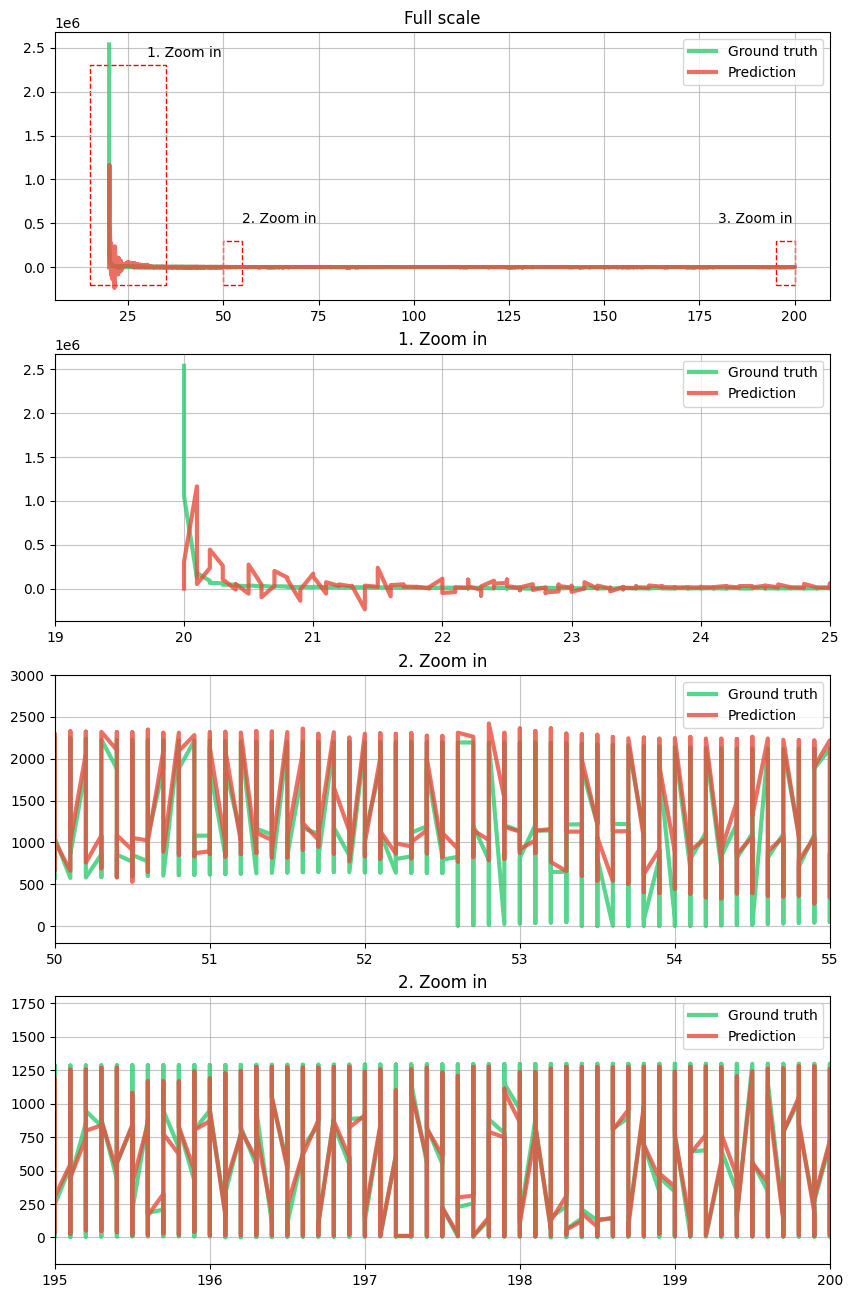

In [367]:
plot_results_4_1(time, y_trues, y_preds)

In [364]:
## Second imporvement

In [441]:
dataset = stream.iter_csv('dataset_VoIP-UL_car_low_traffic_20221007.csv', 
                      converters={
                          'timeStep': float,
                          'vehId': int,
                          'lastPosX': float,
                          'lastPosY': float,
                          'lastVelocity': float,
                          'lastOrientation': float,
                          'distance': float,
                          'measuredSinrUl': float,
                          'measuredSinrDl': float,
                          'rcvdSinrUl': float,
                          'rcvdSinrDl': float,
                          'averageCqiUl': float,
                          'averageCqiDl': float,
                          'servingCell': float,
                          'voIPGeneratedThroughput': float,
                          'macDelayUl': float
                      }, 
                      #parse_dates={'moment': '%Y-%m-%d %H:%M:%S'},
                      target='voIPGeneratedThroughput'
                     )

In [442]:
model = compose.Pipeline(
    ('select', compose.Select('vehId', 'lastPosX', 'lastPosY', 'lastVelocity', 
                       'lastOrientation', 'distance', 'measuredSinrUl', 
                       'measuredSinrDl', 'rcvdSinrUl', 'rcvdSinrDl', 
                       'averageCqiUl', 'averageCqiDl', 'servingCell',
                       'macDelayUl')),
    ('scale', preprocessing.StandardScaler()),
    ('arf_reg', ensemble.AdaptiveRandomForestRegressor(
                seed=42,
                n_models = 100,
                leaf_model=linear_model.LinearRegression(
                    intercept_lr=0,
                    optimizer=optim.SGD(0.03))
                                                      ))
)

In [443]:
#model = preprocessing.TargetStandardScaler(regressor=model)

In [434]:
metric = utils.Rolling(metrics.MAE(), 12)

time = []
y_trues = []
y_preds = []

for x, y in dataset:

    # Obtain the prior prediction and update the model in one go
    y_pred = model.predict_one(x)
    model.learn_one(x, y)

    # Update the error metric
    metric.update(y, y_pred)

    # Store the true value and the prediction
    time.append(x['timeStep'])
    y_trues.append(y)
    y_preds.append(y_pred)

In [435]:
metric

MAE: 41.346977

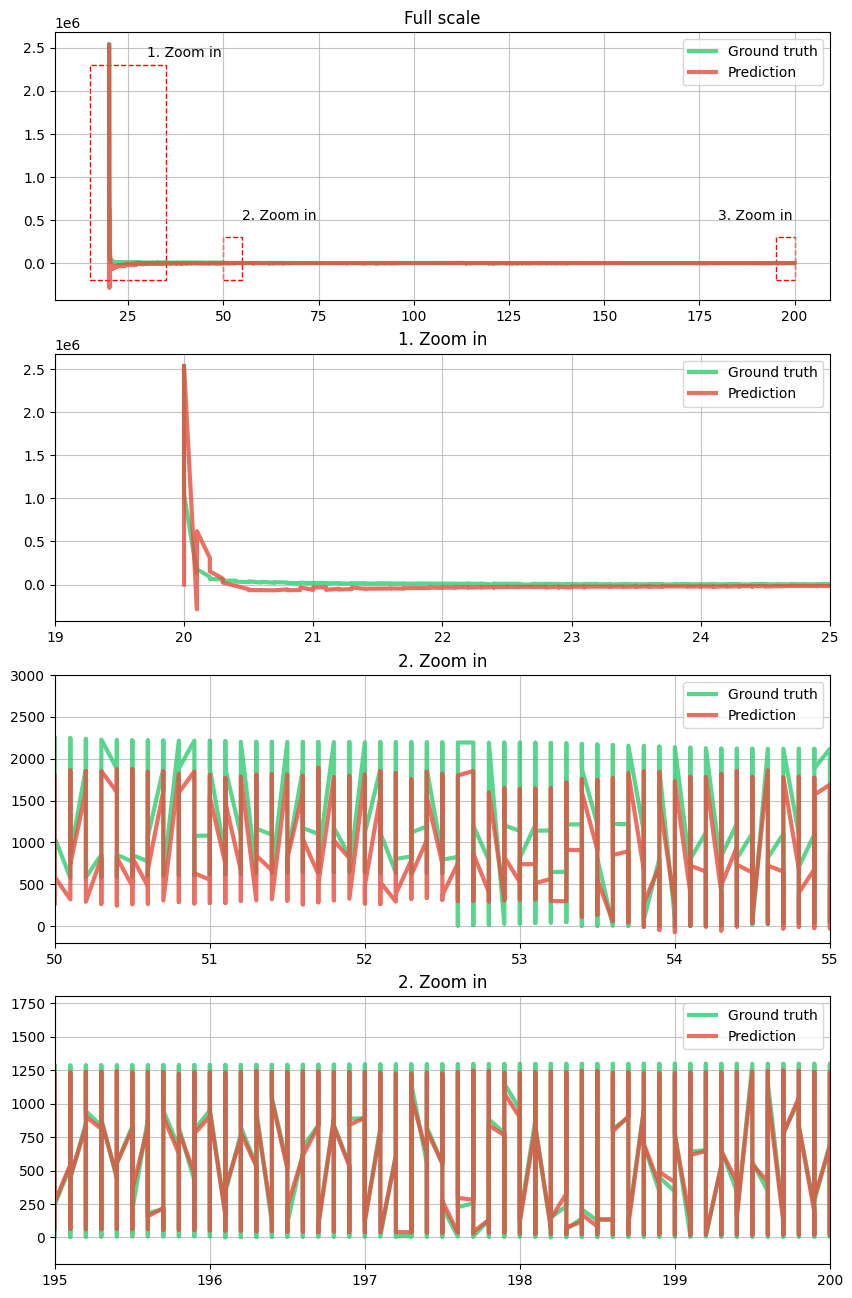

In [402]:
plot_results_4_1(time, y_trues, y_preds)

In [12]:
## Test on Delayed Progressive Validation

In [25]:
dataset = stream.iter_csv('dataset_VoIP-UL_car_low_traffic_20221007.csv', 
                      converters={
                          'timeStep': float,
                          'vehId': int,
                          'lastPosX': float,
                          'lastPosY': float,
                          'lastVelocity': float,
                          'lastOrientation': float,
                          'distance': float,
                          'measuredSinrUl': float,
                          'measuredSinrDl': float,
                          'rcvdSinrUl': float,
                          'rcvdSinrDl': float,
                          'averageCqiUl': float,
                          'averageCqiDl': float,
                          'servingCell': float,
                          'voIPGeneratedThroughput': float,
                          'macDelayUl': float
                      }, 
                      parse_dates={'moment': '%Y-%m-%d %H:%M:%S'},
                      target='voIPGeneratedThroughput'
                     )

In [23]:
x, y = iter(next(dataset))

In [24]:
x

{'timeStep': 20.0,
 'vehId': 0,
 'lastPosX': 302.15811971056,
 'lastPosY': 29.8,
 'lastVelocity': 27.148757453116,
 'lastOrientation': 0.0,
 'distance': 4231.1422207144,
 'measuredSinrUl': 7.0411964453854,
 'measuredSinrDl': 29.718563099652,
 'rcvdSinrUl': -2.4662807148702,
 'rcvdSinrDl': 0.0,
 'averageCqiUl': 5.0,
 'averageCqiDl': 0.0,
 'servingCell': 2.0,
 'macDelayUl': 0.004,
 'moment': datetime.datetime(1970, 1, 1, 1, 0, 20)}

In [26]:
model = compose.Pipeline(
    ('select', compose.Select('vehId', 'lastPosX', 'lastPosY', 'lastVelocity', 
                       'lastOrientation', 'distance', 'measuredSinrUl', 
                       'measuredSinrDl', 'rcvdSinrUl', 'rcvdSinrDl', 
                       'averageCqiUl', 'averageCqiDl', 'servingCell',
                       'macDelayUl')),
    ('scale', preprocessing.StandardScaler()),
    ('arf_reg', ensemble.AdaptiveRandomForestRegressor(seed=42))
)

metric = utils.Rolling(metrics.MAE(), 12)

In [27]:
model

Pipeline (
  Select (
    averageCqiDl
    averageCqiUl
    distance
    lastOrientation
    lastPosX
    lastPosY
    lastVelocity
    macDelayUl
    measuredSinrDl
    measuredSinrUl
    rcvdSinrDl
    rcvdSinrUl
    servingCell
    vehId
  ),
  StandardScaler (
    with_std=True
  ),
  []
)

In [28]:
from datetime import timedelta

evaluate.progressive_val_score(
    dataset=dataset,
    model=model.clone(),
    metric=metric,
    moment='moment',
    delay=timedelta(seconds=5),
    print_every=500
)

[500] MAE: 723.752233
[1,000] MAE: 342.66774
[1,500] MAE: 237.736889
[2,000] MAE: 768.266588
[2,500] MAE: 249.009462
[3,000] MAE: 105.58067
[3,500] MAE: 101.379037
[4,000] MAE: 86.791018
[4,500] MAE: 87.56606
[5,000] MAE: 106.058052
[5,500] MAE: 124.848249
[6,000] MAE: 103.941416
[6,500] MAE: 102.513599
[7,000] MAE: 100.182237
[7,500] MAE: 71.514448
[8,000] MAE: 100.374021
[8,500] MAE: 108.052745
[9,000] MAE: 111.298956
[9,500] MAE: 117.418962
[10,000] MAE: 87.208649
[10,500] MAE: 92.028372
[11,000] MAE: 74.61195
[11,500] MAE: 60.297615
[12,000] MAE: 83.912991
[12,500] MAE: 83.331215
[13,000] MAE: 72.358929
[13,500] MAE: 74.77696
[14,000] MAE: 71.930683
[14,500] MAE: 78.907268
[15,000] MAE: 53.908377
[15,500] MAE: 79.595797
[16,000] MAE: 51.497216
[16,500] MAE: 47.278355
[17,000] MAE: 58.382787
[17,500] MAE: 51.115142
[18,000] MAE: 42.036974
[18,500] MAE: 59.226252
[19,000] MAE: 50.345399
[19,500] MAE: 43.572415
[20,000] MAE: 78.055688
[20,500] MAE: 91.603218
[21,000] MAE: 74.20933
[21

MAE: 49.292209

In [ ]:
time = []
y_trues = []
y_preds = []

for x, y in dataset:

    # Obtain the prior prediction and update the model in one go
    y_pred = model.predict_one(x)
    model.learn_one(x, y)

    # Update the error metric
    metric.update(y, y_pred)

    # Store the true value and the prediction
    time.append(x['timeStep'])
    y_trues.append(y)
    y_preds.append(y_pred)

In [446]:
#
#   Hello World server in Python
#   Binds REP socket to tcp://*:5555
#   Expects b"Hello" from client, replies with b"World"
#

import time
import zmq

context = zmq.Context()
socket = context.socket(zmq.REP)
socket.bind("tcp://*:5555")

while True:
    #  Wait for next request from client
    message = socket.recv()
    print(f"Received request: {message}")

    #  Do some 'work'
    time.sleep(1)

    #  Send reply back to client
    socket.send(b"World")

KeyboardInterrupt: 

In [414]:
import calendar


def get_month(x):
    return {
        calendar.month_name[month]: month == x['month'].month
        for month in range(1, 13)
    }


model = compose.Pipeline(
    ('features', compose.TransformerUnion(
        ('ordinal_date', compose.FuncTransformer(get_ordinal_date)),
        ('month', compose.FuncTransformer(get_month)),
    )),
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LinearRegression(intercept_lr=0))
)

model = preprocessing.TargetStandardScaler(regressor=model)



In [417]:
get_month(x)

{'January': True,
 'February': False,
 'March': False,
 'April': False,
 'May': False,
 'June': False,
 'July': False,
 'August': False,
 'September': False,
 'October': False,
 'November': False,
 'December': False}

In [7]:
## Bike-sharing forecasting

In [8]:
dataset = datasets.Bikes()

In [10]:
for x, y in dataset:
    pprint(x)
    print(f'Number of available bikes: {y}')
    break

{'clouds': 75,
 'description': 'light rain',
 'humidity': 81,
 'moment': datetime.datetime(2016, 4, 1, 0, 0, 7),
 'pressure': 1017.0,
 'station': 'metro-canal-du-midi',
 'temperature': 6.54,
 'wind': 9.3}
Number of available bikes: 1


In [15]:
model = compose.Select('clouds', 'humidity', 'pressure', 'temperature', 'wind')

In [16]:
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression(optimizer=optim.SGD(0.001))

In [17]:
metric = metrics.MAE()

In [18]:
evaluate.progressive_val_score(dataset, model, metric, print_every=20_000)

[20,000] MAE: 4.912727
[40,000] MAE: 5.333554
[60,000] MAE: 5.330948
[80,000] MAE: 5.392313
[100,000] MAE: 5.423059
[120,000] MAE: 5.541223
[140,000] MAE: 5.613023
[160,000] MAE: 5.622428
[180,000] MAE: 5.567824


MAE: 5.563893

In [20]:
def get_hour(x):
    x['hour'] = x['moment'].hour
    return x

In [21]:
model = compose.Select('clouds', 'humidity', 'pressure', 'temperature', 'wind')
model += (
    get_hour |
    feature_extraction.TargetAgg(by=['station', 'hour'], how=stats.Mean())
)
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression(optimizer=optim.SGD(0.001))

In [22]:
metric = metrics.MAE()

In [23]:
evaluate.progressive_val_score(dataset, model, metric, print_every=20_000)

[20,000] MAE: 3.721246
[40,000] MAE: 3.829972
[60,000] MAE: 3.845068
[80,000] MAE: 3.910259
[100,000] MAE: 3.888652
[120,000] MAE: 3.923727
[140,000] MAE: 3.980953
[160,000] MAE: 3.950034
[180,000] MAE: 3.934545


MAE: 3.933498

In [24]:
model

Pipeline (
  TransformerUnion (
    Select (
      clouds
      humidity
      pressure
      temperature
      wind
    ),
    Pipeline (
      FuncTransformer (
        func="get_hour"
      ),
      TargetAgg (
        by=['station', 'hour']
        how=Mean ()
        target_name="y"
      )
    )
  ),
  StandardScaler (
    with_std=True
  ),
  LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.001
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
)

In [25]:
import itertools

In [26]:
model = compose.Select('clouds', 'humidity', 'pressure', 'temperature', 'wind')
model += (
    get_hour |
    feature_extraction.TargetAgg(by=['station', 'hour'], how=stats.Mean())
)
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression()

In [27]:
for x, y in itertools.islice(dataset, 10000):
    y_pred = model.predict_one(x)
    model.learn_one(x, y)

In [28]:
x, y = next(iter(dataset))
print(model.debug_one(x))

0. Input
--------
clouds: 75 (int)
description: light rain (str)
humidity: 81 (int)
moment: 2016-04-01 00:00:07 (datetime)
pressure: 1,017.00000 (float)
station: metro-canal-du-midi (str)
temperature: 6.54000 (float)
wind: 9.30000 (float)

1. Transformer union
--------------------
    1.0 Select
    ----------
    clouds: 75 (int)
    humidity: 81 (int)
    pressure: 1,017.00000 (float)
    temperature: 6.54000 (float)
    wind: 9.30000 (float)

    1.1 get_hour | y_mean_by_station_and_hour
    -----------------------------------------
    y_mean_by_station_and_hour: 4.43243 (float)

clouds: 75 (int)
humidity: 81 (int)
pressure: 1,017.00000 (float)
temperature: 6.54000 (float)
wind: 9.30000 (float)
y_mean_by_station_and_hour: 4.43243 (float)

2. StandardScaler
-----------------
clouds: 0.47566 (float)
humidity: 0.42247 (float)
pressure: 1.05314 (float)
temperature: -1.22098 (float)
wind: 2.21104 (float)
y_mean_by_station_and_hour: -0.59098 (float)

3. LinearRegression
-----------------

In [29]:
import datetime as dt

In [31]:
evaluate.progressive_val_score(
    dataset=dataset,
    model=model.clone(),
    metric=metrics.MAE(),
    moment='moment',
    delay=dt.timedelta(minutes=5),
    print_every=20_000
)

[20,000] MAE: 3.410028
[40,000] MAE: 3.516551
[60,000] MAE: 3.521252
[80,000] MAE: 3.580592
[100,000] MAE: 3.561489
[120,000] MAE: 3.592553
[140,000] MAE: 3.635116
[160,000] MAE: 3.597379
[180,000] MAE: 3.56331


MAE: 3.560689

In [165]:
df = pd.read_csv('dataset_VoIP-UL_car_high_traffic_20221007.csv')

In [166]:
df = df.sort_values(by=['timeStep'])

In [167]:
df = df.reset_index()

In [168]:
df = df.drop(columns=['index'])

In [169]:
df['moment'] = ' '

In [172]:
df

,timeStep,vehId,lastPosX,lastPosY,lastVelocity,lastOrientation,distance,measuredSinrUl,measuredSinrDl,rcvdSinrUl,rcvdSinrDl,averageCqiUl,averageCqiDl,servingCell,voIPGeneratedThroughput,macDelayUl,moment
0,20.0,0,541.087532,29.8,30.452425,0.000000,3994.205299,17.116367,27.769163,18.755977,0.000000,9.0,0.0,2.0,3.077700e+06,0.004,1970-01-01 01:00:20
1,20.0,3,4563.527717,23.4,30.637405,-3.141593,527.241245,0.077157,27.860903,6.575536,0.000000,7.0,0.0,1.0,1.394529e+06,0.004,1970-01-01 01:00:20
2,20.0,4,4663.170907,23.4,26.267887,-3.141593,548.244749,-0.512403,25.523254,-7.770040,0.000000,2.0,0.0,1.0,2.786395e+04,0.010,1970-01-01 01:00:20
3,20.0,5,624.954275,26.6,42.727607,0.000000,3910.663234,12.776072,30.925893,14.388498,0.000000,8.0,0.0,0.0,1.273019e+04,0.004,1970-01-01 01:00:20
4,20.0,6,315.373007,26.6,24.053560,0.000000,4217.630926,11.712742,28.259047,13.215440,0.000000,7.0,0.0,2.0,1.057817e+06,0.004,1970-01-01 01:00:20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189278,200.0,62,2110.611674,20.2,25.309864,-3.141593,2445.359812,-9.581290,18.280317,-8.547997,19.192588,2.0,10.0,1.0,1.126919e+03,0.010,1970-01-01 01:03:20
189279,200.0,120,1542.769117,29.8,32.122838,0.000000,3004.313987,7.479827,23.536430,7.474684,27.833776,5.0,12.0,0.0,6.111359e+02,0.004,1970-01-01 01:03:20
189280,200.0,147,4452.454826,20.2,21.106585,-3.141593,522.368245,7.843529,28.939549,10.609957,29.763752,5.0,13.0,0.0,2.684576e+02,0.004,1970-01-01 01:03:20
189281,200.0,64,4160.181839,26.6,32.603739,0.000000,626.724774,13.669494,31.546412,29.392214,35.978696,13.0,13.0,2.0,9.369381e+02,0.004,1970-01-01 01:03:20


In [171]:
for n in range(df.shape[0]):
    #print(df.iloc[n].moment)
    moment = datetime.fromtimestamp(df.iloc[n].timeStep).strftime('%Y-%m-%d %H:%M:%S')
    df['moment'].iloc[n] = moment

/tmp/ipykernel_580725/4282854640.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['moment'].iloc[n] = moment


In [173]:
df.to_csv('dataset_VoIP-UL_car_high_traffic_20221007.csv', index=False)

In [154]:
df.iloc[1500].moment

'1970-01-01 01:00:48'